# 2) Relación Entre Viajes En Bicicleta y el Clima

In [46]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trips = pd.read_csv('data/trip.csv', low_memory=False)
weather = pd.read_csv('data/weather.csv', low_memory=False)
station = pd.read_csv('data/station.csv', low_memory=False)
#Se convierte los dates a datetime64[ns].
trips['start_date'] = pd.to_datetime(trips['start_date'])
weather['date'] = pd.to_datetime(weather['date'])

In [3]:
#Se agrega una nueva columna date que coincide con weather.
trips['date'] = trips['start_date'].apply(lambda x: x.date())
#Se convierte date a datetime64[ns].
trips['date'] = pd.to_datetime(trips['date'])

In [4]:
#Formula para convertir F a C.
def f_to_c(f_temp):
    return round((f_temp - 32) / 1.8, 2)

In [5]:
#Se crean columnas con las temperaturas en C.
weather['max_temperature_c'] = weather['max_temperature_f'].map(f_to_c)
weather['mean_temperature_c'] = weather['mean_temperature_f'].map(f_to_c)
weather['min_temperature_c'] = weather['min_temperature_f'].map(f_to_c)

In [6]:
#Se crean columnas con visibilidad en Km.
weather['max_visibility_km'] = weather['max_visibility_miles'].map(lambda x: x * 1.6)
weather['mean_visibility_km'] = weather['mean_visibility_miles'].map(lambda x: x * 1.6)
weather['min_visibility_km'] = weather['min_visibility_miles'].map(lambda x: x * 1.6)

In [7]:
#Funcion para convertir la duracion de segundos a minutos.
def s_to_m(time):
    return (time / 60)
#Funcion para convertir la duracion de segundos a horas redondeo a 3 decimales.
def s_to_h(time):
    return round((time / 3600),3)

In [8]:
#Se crea una columna con la duracion en minutos y la duracion en horas.
trips['duration_m'] = trips['duration'].map(s_to_m)
trips['duration_h'] = trips['duration'].map(s_to_h)

In [9]:
#Funcion para clasificar estaciones climaticas.
def estacion(date):
    if date.month >= 3 and date.month <= 5:
        return 'Primavera'
    elif date.month >= 6 and date.month <= 8:
        return 'Verano'
    elif date.month >= 9 and date.month <= 11:
        return 'Otoño'
    else:
        return 'Invierno'

In [10]:
#Se crea la columna con la estacion climatica.
trips['estacion_clima'] = trips['date'].map(estacion)

In [11]:
#Se filtran las duraciones menores o iguales a 3 minutos con la misma estacion de salida y llegada.
trips = trips[-((trips['duration_m'] <= 3.0) & (trips['start_station_id'] == trips['end_station_id']))]

Este filtrado se realiza porque si el viaje duro menos de 3 minutos y termino en la misma estación que comenzó, entonces se puede pensar que hubo un desperfecto técnico en la bicicleta o que el usuario desistió de realizar el viaje, es decir, el viaje no se concreto.

In [12]:
#Se hace join de trips y station para obtener la ciudad en la cual comenzo el viaje.
#Se renombra el id de trips a id_trip.
trips.rename(columns={'id':'id_trip'}, inplace=True)
station_aux = station[['id', 'city']]
joined_trips_station = trips.merge(station, left_on=['start_station_id'], right_on=['id'])

In [13]:
#Funcion para clasificar la ciudad dependiendo del zipcode.
#La clasificacion se basa en los zip_codes obtenidos en https://www.unitedstateszipcodes.org/.
def zip_ciudad(zip_code):
    if zip_code == 95113:
        return 'San Jose'
    elif zip_code == 94301:
        return 'Palo Alto'
    elif zip_code == 94107:
        return 'San Francisco'
    elif zip_code == 94063:
        return 'Redwood City'
    else:
        return 'Mountain View'

In [14]:
#Se crea una columna city en weather para que coindida con joined_trips_station.
weather['city'] = weather['zip_code'].map(zip_ciudad)

In [15]:
#Se mergean los DataFrames Weather y joined_trips_station en uno solo.
joined = joined_trips_station.merge(weather, left_on=['date', 'city'], right_on=['date', 'city'])

## 2.1) ¿Como se relacionan los viajes en bicicleta y la temperatura?

En esta serie de plots se analizará si hay una correlación entre los viajes en bicicleta y la temperatura.

Como los registros del clima están en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climáticas para decidir si realizar un viaje o no. Ademas, siguiendo el mismo criterio, se utiliza como localización para el clima a la localización de la estación de partida.

### 2.1.A) Histograma del Promedio de Temperatura

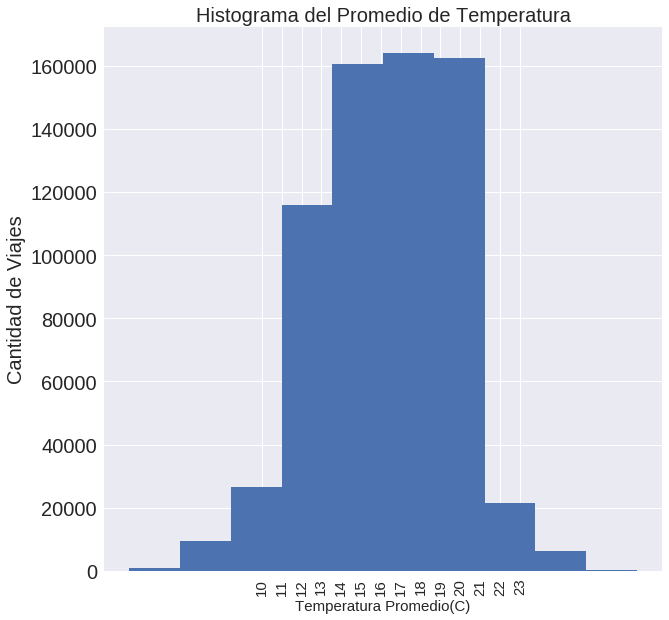

In [16]:
joined.hist(column='mean_temperature_c', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(10,24,1));
plt.xlabel('Temperatura Promedio(C)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma del Promedio de Temperatura', fontsize=20);

En este histograma se puede apreciar que la mayor cantidad de los viajes se realizan cuando la temperatura promedio esta entre 11°C y 21°C.  
Si bien puede parecer que la temperatura es algo baja, hay que tener en cuenta que esto es un promedio de la temperatura de todo el día y como San Francisco es una ciudad costera la temperatura suele bajar bastante sobre la noche.

### 2.1.B) Histograma de la Temperatura Máxima

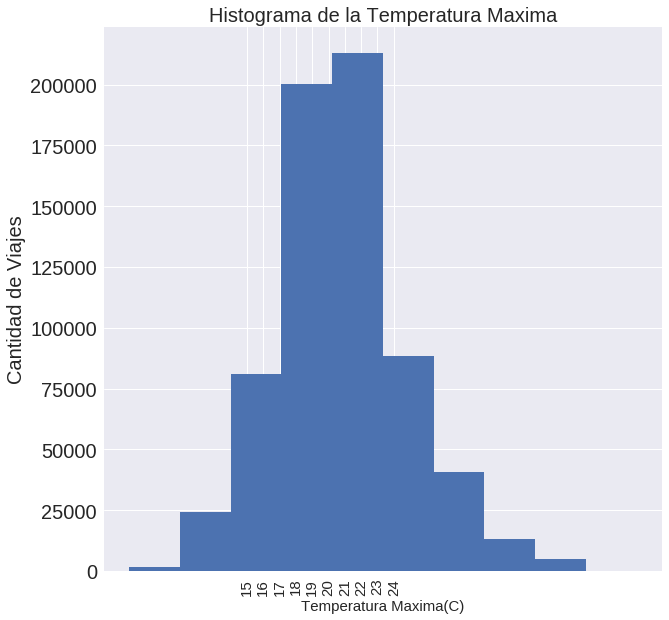

In [17]:
joined.hist(column='max_temperature_c', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(15,25,1));
plt.xlabel('Temperatura Maxima(C)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de la Temperatura Maxima', fontsize=20);

De este histograma se puede obtener que la mayoria de los viajes se realizan cuando la temperatura maxima esta entre 17°C y 23°C.

Si se toman en cuenta los dos histogramas en conjunto, se puede apreciar que la mayoría de las personas buscan temperaturas templadas a la hora de realizar los viajes.  
No es necesario analizar la temperatura mínima, ya que como se dijo antes, la temperatura suele bajar mucho sobre la noche y daría resultados engañosos.

### 2.1.C) Dias con mayor uso simultaneo de Bicicletas y la Temperatura

In [18]:
#Funciones para clasificar.
def f_st(row):
    if row['event'] == 'start_date':
        val = 1
    else:
        val = 0
    return val

def f_en(row):
    if row['event'] == 'end_date':
        val = 1
    else:
        val = 0
    return val

In [19]:
trips_station_aux = joined_trips_station[['id_trip', 'start_date', 'end_date', 'city']]
trips_station_melt = pd.melt(trips_station_aux, id_vars=['id_trip','city'], value_vars=['start_date', 'end_date'], var_name='event', value_name='time')
trips_station_melt['time'] = pd.to_datetime(trips_station_melt['time'])

In [20]:
#Se obtiene la cantidad de bicicletas en uso al mismo tiempo.
trips_station_ord = trips_station_melt.sort_values('time', ascending=True) 
trips_station_ord['start_counter'] = trips_station_ord.apply(f_st, axis=1)
trips_station_ord['end_counter'] = trips_station_ord.apply(f_en, axis=1)
trips_station_ord['start'] = trips_station_ord['start_counter'].cumsum()
trips_station_ord['end'] = trips_station_ord['end_counter'].cumsum()
trips_station_ord = trips_station_ord[['id_trip', 'city', 'time', 'start', 'end']]
trips_station_ord['in_use'] = trips_station_ord['start'] - trips_station_ord['end']
trips_station_ord = trips_station_ord.sort_values('in_use', ascending=False)

In [21]:
#Se eliminan los horarios para coincidir con weather.csv.
trips_station_ord['time'] = trips_station_ord['time'].apply(lambda x: x.date())
#Se convierte time a datetime64[ns].
trips_station_ord['time'] = pd.to_datetime(trips_station_ord['time'])

In [22]:
#Se combinan los Dataframes.
joined_simul = trips_station_ord.merge(weather, left_on=['time', 'city'], right_on=['date', 'city'])

In [23]:
#Solo hay que quedarse con el maximo de bicicletas simultaneas para ese dia.
joined_max_simul = joined_simul.drop_duplicates(subset=['time'], keep='first')

In [24]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_bar = joined_max_simul[:10]
joined_max_simul_bar = joined_max_simul_bar[['time', 'mean_temperature_c', 'max_temperature_c']]
joined_max_simul_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de temperatura) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su temperatura promedio y temperatura máxima. La localización tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

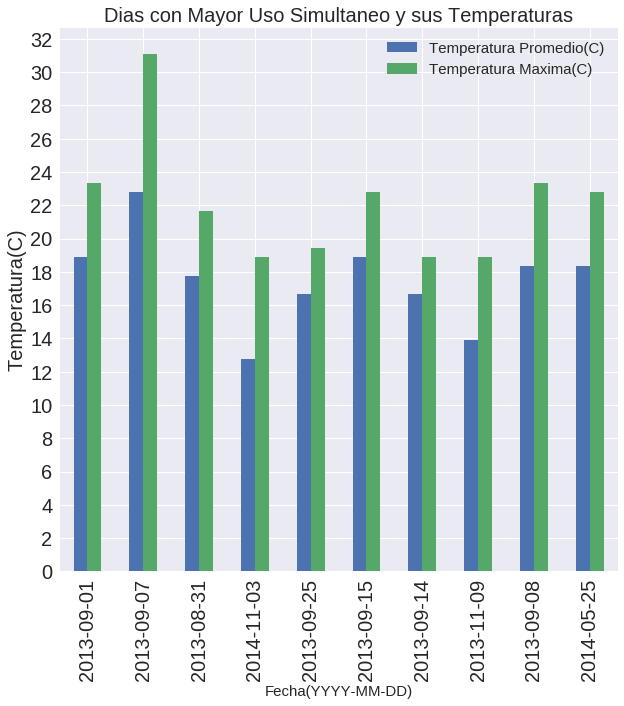

In [25]:
bar = joined_max_simul_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_bar.index.format());
plt.yticks(range(0,33,2));
plt.xlabel('Fecha(YYYY-MM-DD)', fontsize=15);
plt.ylabel('Temperatura(C)', fontsize=20);
plt.title('Dias con Mayor Uso Simultaneo y sus Temperaturas', fontsize=20);
plt.legend(['Temperatura Promedio(C)', 'Temperatura Maxima(C)'], fontsize=15);

Del este plot podemos obtener los siguientes puntos:  
* El primer punto importante es ver que el segundo día con mayor uso simultaneo tiene una temperatura máxima de 31°C y una temperatura promedio de 23°C. Este día claramente tiene temperaturas mucho más elevadas que los días restantes, por lo tanto, se puede tomar como una anomalía.
* El segundo punto importante a notar es que la mayoría de estos días tienen temperaturas templadas, es decir, sus temperaturas promedio varían entre 13°C y 19°C mientras que sus temperaturas máximas están entre 19°C y 23°C.  
* Por ultimo, es evidente que si bien la cantidad de bicicletas en uso simultáneamente decrece a lo largo del gráfico de barras, las temperaturas se mantienen siempre dentro de un mismo rango.

### 2.1.D) Conclusión de Viajes y Temperatura

Usando los plots anteriores se puede concluir que la mayor cantidad de viajes se realizan cuando la temperatura es templada, es decir, cuando esta alrededor de los 20°C.
Para describir este fenómeno hay que tener en cuenta los motivos por los cuales se podría realizar un viaje, para simplificar se tomaran dos casos:
1. En el caso de que se quiera realizar un viaje por la necesidad de trasladarse, la temperatura no afecta mucho, excepto en casos de muy bajas o muy altas temperaturas.
2. El caso en el cual se quiere realizar un viaje por placer es el que interesa, ya que es aquí cuando la temperatura juega un rol importante. Con temperaturas templadas las personas estarán mas predispuestas a realizar viajes en bicicleta, como muestran los plots obtenidos. 

Por ultimo, es importante notar que las mejores temperaturas se suelen presentar sobre la media mañana, ya que el sol todavía no esta en su punto más alto, y sobre la tarde, ya que es cuando comienza a bajar el sol, por eso no seria extraño que la mayor cantidad de los viajes se realicen en horarios de la media mañana o de la tarde.

## 2.2) ¿Como se relacionan los viajes y la visibilidad?

En la siguiente serie de plots se tratara de analizar si hay una correlación entre los viajes en bicicletas y la visibilidad.  

Como los registros del clima están en forma diurna, es necesario tomar las fechas del viaje sin horarios. Para todos los plots se toma como fecha del viaje a la fecha de inicio del mismo, esto se debe a que es el momento en el cual la persona toma en cuenta las condiciones climáticas para decidir si realizar un viaje o no. Ademas, siguiendo el mismo criterio, se utiliza como localización para el clima a la localización de la estación de partida.

### 2.2.A)  Grafico de Barras de Visibilidad Promedio y Histograma de Visibilidad Promedio

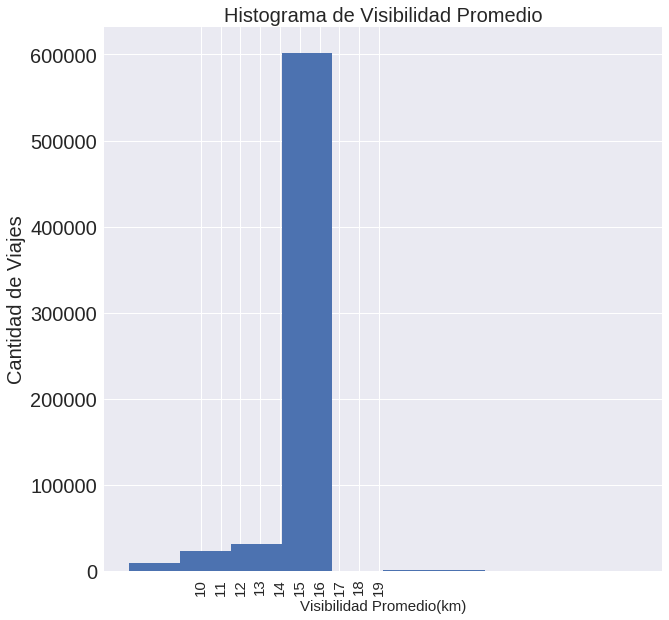

In [26]:
joined.hist(column='mean_visibility_km', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(10,20,1));
plt.xlabel('Visibilidad Promedio(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de Visibilidad Promedio', fontsize=20);

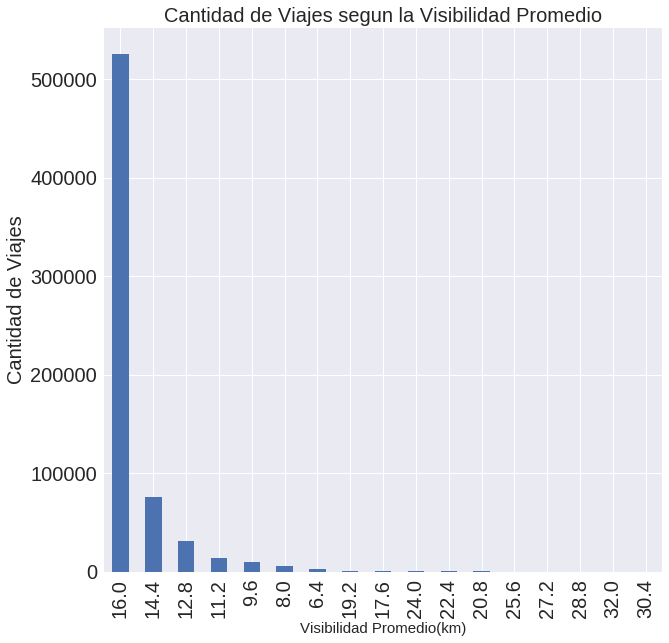

In [27]:
joined['mean_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Promedio(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Promedio', fontsize=20);

De este plot se pueden extraer tres puntos importantes:  
* La mayoría de los viajes en bicicleta se realizan cuando la visibilidad promedio es de 16km.
* Por encima de los 16km de visibilidad promedio hay escasez de datos, por lo tanto, se puede intuir que no es normal que en San Francisco se presenten visibilidades promedio tan elevadas.  
* Sino se toman en cuenta las visibilidades promedio mayores a 16km(porque no hay datos suficientes), la diferencia entre las visibilidades promedio mayores o iguales a 14.4km y las menores a esta es abismal. Esto no es un dato menor, ya que hay que tener una buena visibilidad al realizar un viaje para que este sea seguro y queda claro, por esta diferencia, que el usuario prioriza mucho la seguridad.

Ahora seria importante analizar que sucede con la visibilidad mínima, ya que por cuestiones de seguridad es importante que haya una buena visibilidad mínima para evitar accidentes.

### 2.2.B) Grafico de Barras de Visibilidad Mínima y Histograma de Visibilidad Mínima

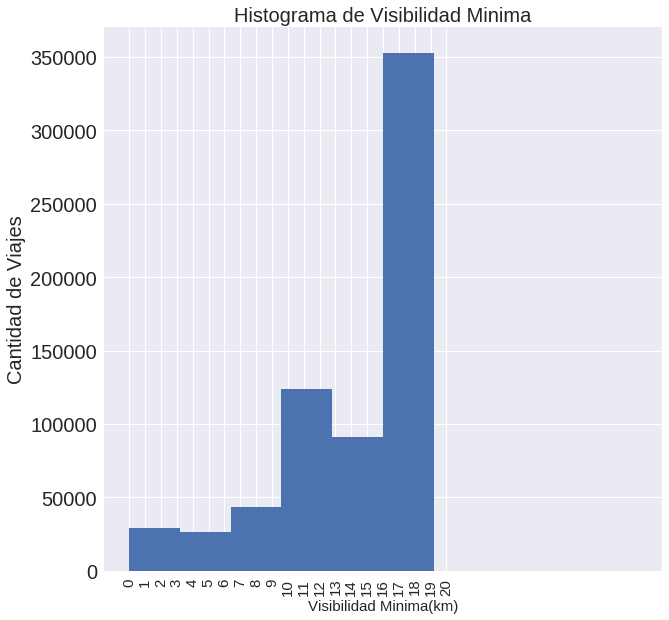

In [28]:
joined.hist(column='min_visibility_km', grid=True, figsize=(10,10), xrot=90, xlabelsize=15, ylabelsize=20);
plt.xticks(range(0,21,1));
plt.xlabel('Visibilidad Minima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Histograma de Visibilidad Minima', fontsize=20);

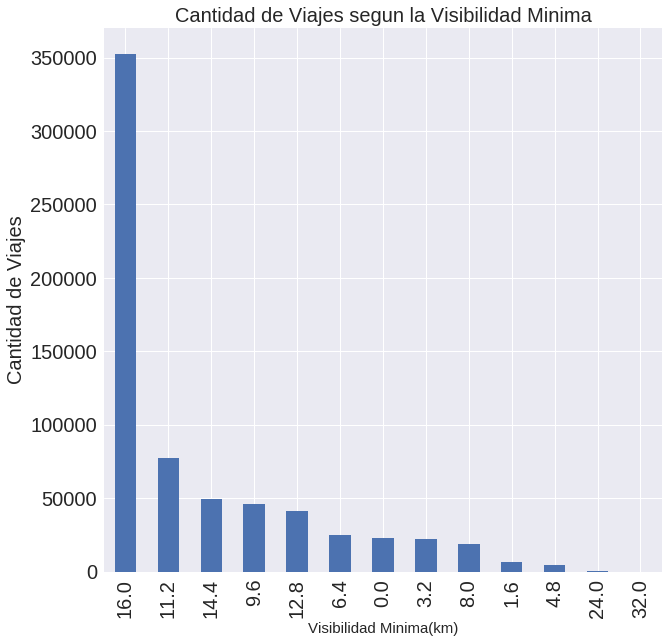

In [29]:
joined['min_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Minima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Minima', fontsize=20);

En estos dos plots se apreciar de nuevo que la mayor cantidad de viajes se realiza cuando la visibilidad mínima es de 16km. Ademas es importante notar que de nuevo se manifiesta la gran separación entre la visibilidad de 16km y las que son menores a esta. Por ejemplo, si tomamos la visibilidad mínima de 11.2km podemos ver que hay una diferencia aproximada de 275000 viajes con la visibilidad de 16km.

### 2.2.C) Grafico de Barras de Visibilidad Máxima

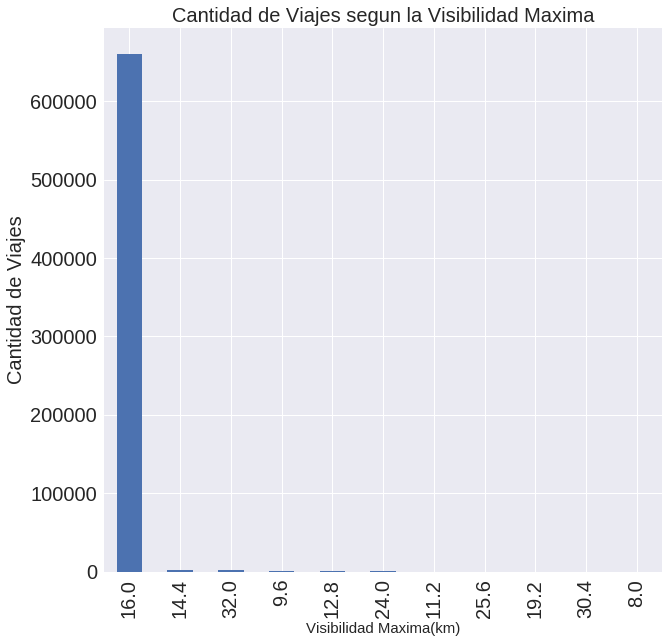

In [30]:
joined['max_visibility_km'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Visibilidad Maxima(km)', fontsize=15);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Visibilidad Maxima', fontsize=20);

De este plot es muy difícil sacar conclusiones ya que la diferencia de la visibilidad máxima de 16km con las demás es demasiado grande. Lo único importante a destacar, es que hay una ínfima cantidad de viajes realizados con visibilidades máximas menores o iguales a 10km.

### 2.D) Dias con mayor uso simultaneo de Bicicletas y la Visibilidad

In [31]:
#Nos quedamos con los 10 valores maximos y las columnas que interesan.
joined_max_simul_vis_bar = joined_max_simul[:10]
joined_max_simul_vis_bar = joined_max_simul_vis_bar[['time', 'mean_visibility_km', 'min_visibility_km', 'max_visibility_km']]
joined_max_simul_vis_bar.set_index('time', inplace=True)

En el siguiente gráfico de barras se pueden aprecian los 10 días (de los cuales hay datos de visibilidad) con mayor uso simultaneo de bicicletas(ordenados de forma descendente), junto con su visibilidad promedio, visibilidad mínima y visibilidad máxima. La localización tomada para el clima de cada día, es donde se produce su respectivo pico máximo de bicicletas en uso.

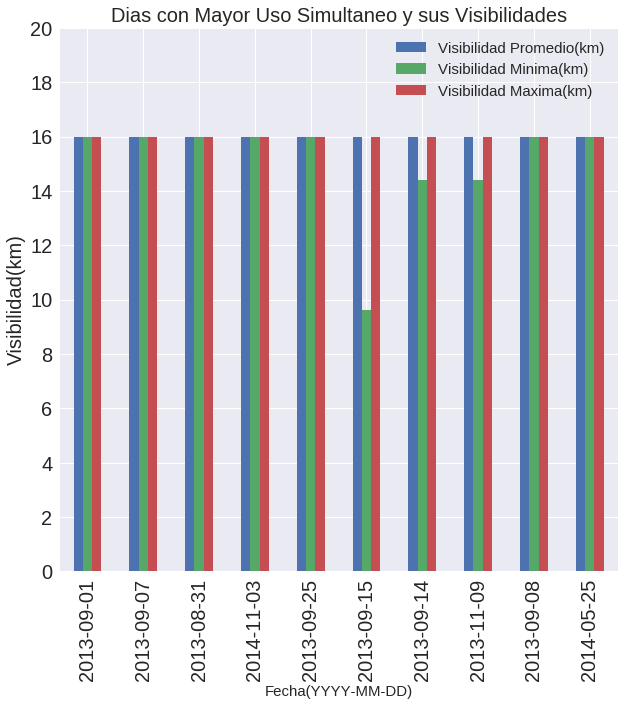

In [32]:
bar = joined_max_simul_vis_bar.plot.bar(figsize=(10,10), fontsize=20);
#Elimina el 00:00:00 del plot.
bar.set_xticklabels(joined_max_simul_vis_bar.index.format());
plt.yticks(range(0,22,2));
plt.xlabel('Fecha(YYYY-MM-DD)', fontsize=15);
plt.ylabel('Visibilidad(km)', fontsize=20);
plt.title('Dias con Mayor Uso Simultaneo y sus Visibilidades', fontsize=20);
plt.legend(['Visibilidad Promedio(km)', 'Visibilidad Minima(km)', 'Visibilidad Maxima(km)'], fontsize=15);

Este plot confirma la tendencia que se había marcado previamente, los 10 días con mayor uso simultaneo de bicicletas presentan visibilidades promedio y visibilidades máximas iguales a los 16km.  
Ademas todos la mayoría de los dias presentan visibilidades mínimas iguales o cercanas a 16km.  
El único caso llamativo es del día 2013-09-15 en el cual la visibilidad mínima es de aproximadamente 9km, pero si bien su visibilidad mínima es baja su visibilidad máxima y visibilidad promedio se mantienen dentro de lo esperado. Esto nos indicaría que la mayor cantidad de viajes de ese día se habría producido en horarios donde la visibilidad era más cercana a la máxima que a la mínima.

### 2.2.E) Conclusión de Viajes y Visibilidad

Dados los plots vistos se puede concluir claramente que la visibilidad máxima, mínima y mediana deben ser de, o al menos cercano a, 16km para que se produzca un mayor uso del servicio de bicicletas. Esto claramente esta relacionado, como ya se menciono antes, con la seguridad, los usuarios tienden a poner a la seguridad como uno de los puntos más importantes a la hora de decidir si realizar un viaje en bicicleta o no.

## 2.3) ¿Como se relacionan los viajes y las estaciones climáticas?

### 2.3.A) Cantidad de Viajes y Estaciones Climáticas

En la siguiente serie de plots se analizará si hay una relación entre los viajes en bicicleta y las estaciones climáticas.

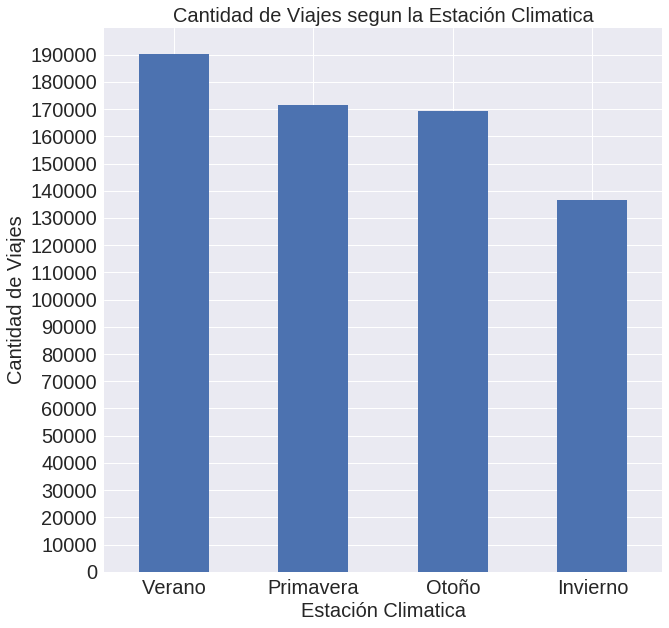

In [33]:
trips['estacion_clima'].value_counts(sort=True).plot.bar(figsize=(10,10), rot=0, fontsize=20);
plt.yticks(range(0,200000,10000))
plt.xlabel('Estación Climatica', fontsize=20);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes segun la Estación Climatica', fontsize=20);

De este plot podemos observar:  
* La estación climática con la mayor cantidad de viajes es Verano. Esto esta dentro de lo esperado ya que en Verano se llega fácilmente a temperaturas de 20°C.  
* Las siguientes dos estaciones son Primavera y Otoño. Esto de nuevo concuerda con lo dicho previamente, en estas estaciones climáticas hay temperaturas que se acercan a 20°C.  
* Por ultimo, es importante notar que todas las estaciones mantienen un piso de 130000 viajes. Esto va de la mano con lo dicho en la sección 2.1.D y 2.2.E, si alguien quiere utilizar el servicio de bicicletas por un motivo no recreativo, no suele darle demasiada importancia a factores climáticos excepto que conlleven un riesgo para su seguridad.

### 2.3.B) Duración promedio de Viajes y Estaciones Climáticas

En este plot se analizará las duraciones promedio de los viajes en cada estación.

In [34]:
grouped_season = trips[['estacion_clima', 'duration_m']].groupby('estacion_clima')\
.aggregate('mean')

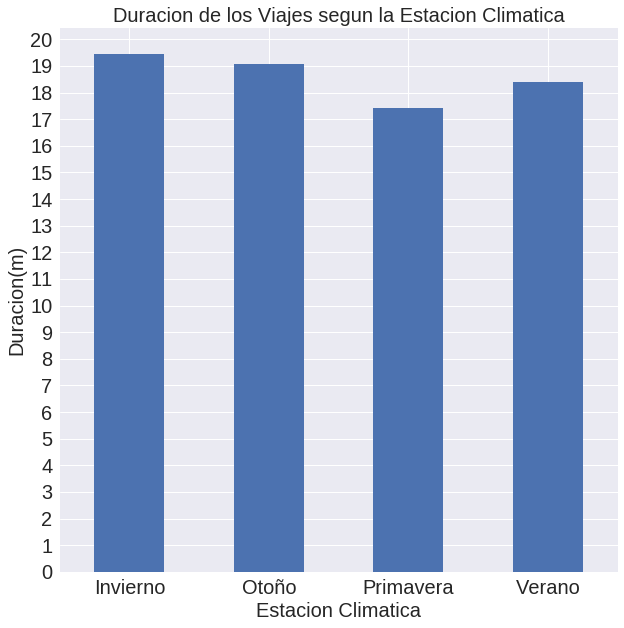

In [35]:
grouped_season.plot.bar(figsize=(10,10), rot=0, fontsize=20);
plt.yticks(range(0,21,1));
plt.xlabel('Estacion Climatica', fontsize=20);
plt.ylabel('Duracion(m)', fontsize=20)
plt.title('Duracion de los Viajes segun la Estacion Climatica', fontsize=20);
plt.legend('');

De este plot podemos hacer tres observaciones importantes:  
* Primero, si bien Invierno es la estación climática con menor cantidad de viajes, es la que tiene la mayor duración promedio.
* Segundo, tanto Verano como Primavera, que son las estaciones climáticas con la mayor cantidad de viajes, tienen las menores duraciones promedio.
* Por ultimo, todas las duraciones promedio se mantienen dentro de un rango bastante pequeño(17m - 19m).

### 2.3.C) Conclusión de Viajes y Estaciones Climáticas

Las conclusiones que se pueden realizar a raíz de los plots a analizados son:  
* Hay una mayor cantidad de viaje en estaciones climáticas donde la temperatura es mas cálida. Ademas la diferencia, en termino de cantidades de viajes, entre Verano e Invierno es bastante grande en favor del Verano.  
* Como se expreso anteriormente, todas las estaciones tienen un piso 130000 viajes. Esto da a entender que una gran parte de los usuarios no pone como prioridad al clima a la hora de realizar un viaje, esto se puede deber a que la mayoría de los usuarios utiliza el servicio de bicicletas como modo de transporte y no como en forma recreativa.

# 2.4) ¿Que sucede con los 5 viajes de mayor duración?

En los siguientes plots se analizara que sucede con la temperatura, visibilidad y estación climática para los 5 viajes con mayor duración. Se utilizan las duraciones menores o iguales a 12 horas porque se considera que un viaje continuado puede durar, como mucho, 12 horas si se permiten interrupciones de duración corta. Ademas se toman solo los viajes que ocurren durante el día para evitar confusiones con bicicletas que olvidaron entregarse.  
Algunos de los motivos por los cuales se pueden realizar viajes largos son, por ejemplo:  
* Realizar un tour de la ciudad de San Francisco.  
* Realizar actividad física intensiva.
* Tener que realizar varios trayectos en horarios diferentes.

In [36]:
#Se obtienen los 5 viajes con mayor duracion (que poseen datos climaticos) menores a 12 horas
#que ocurran durante el dia (se toman solo viajes que comiencen a la mañana).
joined['start_hour'] = joined['start_date'].map(lambda x: x.hour)
top_dur = joined[(joined['start_hour'] >= 7)  & (joined['start_hour'] <= 11) & (joined['duration_h'] <= 12)]
top_dur = top_dur.sort_values('duration_h', ascending=False)[:5]

### 2.4.A) Temperatura de los 5 Viajes con Mayor Duración

In [37]:
top_dur_temp = top_dur[['duration_h', 'max_temperature_c', 'min_temperature_c', 'mean_temperature_c']]
top_dur_temp.set_index('duration_h', inplace=True)

Se muestran los 5 viajes con mayor duración (con sus respectivas duraciones, en horas, como label) ordenados de forma descendente junto con sus respectivas temperaturas máximas, temperaturas mínimas y temperaturas promedio.

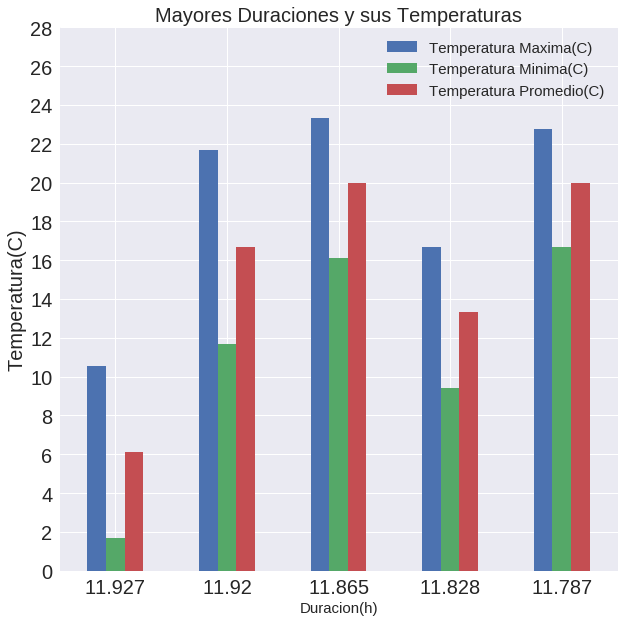

In [38]:
top_dur_temp_bar = top_dur_temp.plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,30,2));
plt.xlabel('Duracion(h)', fontsize=15);
plt.ylabel('Temperatura(C)', fontsize=20);
plt.title('Mayores Duraciones y sus Temperaturas', fontsize=20);
plt.legend(['Temperatura Maxima(C)', 'Temperatura Minima(C)', 'Temperatura Promedio(C)'], fontsize=15);

Dado este plot se puede decir que las temperaturas varían mucho entre los distintos días:  
* La temperatura máxima esta entre aproximadamente 10°C y 23°C.  
* La temperatura mínima esta entre aproximadamente 2°C y 16°C.  
* La temperatura promedio esta entre aproximadamente 6°C y 20°C.  

Esto indica que no hay una relación entre los viajes de mayor duración y la temperatura.

### 2.4.B) Visibilidad de los 5 Viajes con Mayor Duración

In [39]:
top_dur_vis = top_dur[['duration_h', 'max_visibility_km', 'min_visibility_km', 'mean_visibility_km']]
top_dur_vis.set_index('duration_h', inplace=True)

Se muestran los 5 viajes con mayor duración (con sus respectivas duraciones, en horas, como label) ordenados de forma descendente junto con sus respectivas visibilidades máximas, visibilidades mínimas y visibilidades promedio.

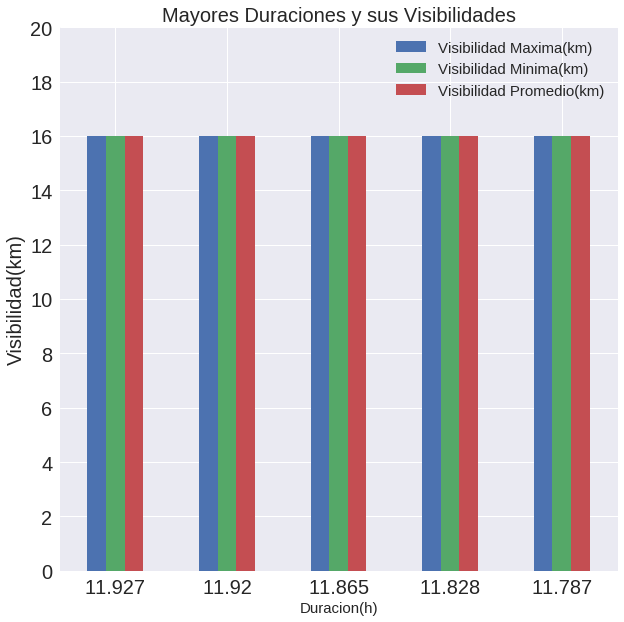

In [40]:
top_dur_vis_bar = top_dur_vis.plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,22,2));
plt.xlabel('Duracion(h)', fontsize=15);
plt.ylabel('Visibilidad(km)', fontsize=20);
plt.title('Mayores Duraciones y sus Visibilidades', fontsize=20);
plt.legend(['Visibilidad Maxima(km)', 'Visibilidad Minima(km)', 'Visibilidad Promedio(km)'], fontsize=15);

Este plot es muy claro e indica que para que se produzcan viajes de esta duración la visibilidad debe ser muy buena, es decir, visibilidad de 16km. Esto esta acorde con lo dicho en la sección 2.2.

### 2.4.C) Estación Climática de los 5 Viajes con Mayor Duracíon

In [41]:
#Se muestran las duracion(en horas) y su respectiva estacion.
top_dur[['duration_h', 'estacion_clima']]

,duration_h,estacion_clima
75462,11.927,Invierno
627501,11.920,Primavera
329714,11.865,Verano
63523,11.828,Otoño
168523,11.787,Verano


Las estaciones climáticas de los viajes de mayor duración, ordenados de mayor a menor, son:  
**1.** Invierno  
**2.** Primavera  
**3.** Verano  
**4.** Otoño   
**5.** Verano  

Dados estos datos se puede decir que:  
* La mayor duración de los 5 viajes se produce en Invierno y la menor duración de los 5 se produce en Verano.
* La distribución de los 5 viajes en las estaciones climáticas es muy pareja, por lo tanto, se puede decir que la estación climática no afecta mucho en la realización de estos viajes.

### 2.4.D) Conclusión del Caso Particular

Según la serie de datos analizados podemos decir que para que se produzcan viajes de gran duración el único requerimiento es que la visibilidad debe ser muy buena (igual a 16km). Ademas si tenemos en cuenta que para realizar estos viajes se requieren muchas horas, podemos decir que estos ocurrirán más en días no laborables o los que realizan este tipo de viajes son turistas.

## 2.5) ¿Como se relacionan los viajes en bicicleta y la lluvia?

En la siguiente serie de plots se analizara si hay una relación entre los viajes en bicicleta y la lluvia.

In [42]:
#Funcion para clasificar lluvia.
def lluvia_y_n(event):
    if isinstance(event, float):
        return 'No'
    elif 'rain' in event.lower():
        return 'Si'
    else:
        return 'No'

In [43]:
joined['lluvia'] = joined['events'].map(lluvia_y_n)

### 2.5.A) Cantidad de Viajes con Lluvia Vs. Cantidad de Viajes sin Lluvia

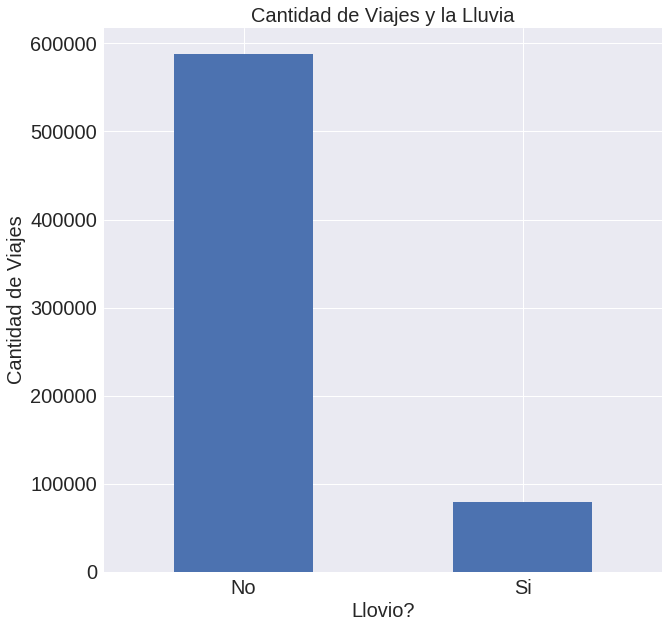

In [44]:
joined['lluvia'].value_counts().plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.xlabel('Llovio?', fontsize=20);
plt.ylabel('Cantidad de Viajes', fontsize=20)
plt.title('Cantidad de Viajes y la Lluvia', fontsize=20);
plt.legend('');

Las observaciones que se hacen de este plot son:  
* Hay una diferencia de casi 500000 viajes a favor de los días en los que no llueve. Por ende, se puede decir que se viaja mucho más cuando no llueve.  
* Los casi 100000 viajes que se producen cuando llueve se pueden deber a que la intensidad de la lluvia es demasiado baja y, por lo tanto, los usuarios optan por seguir viajando.  

### 2.5.B) Duración promedio de los Viajes con Lluvia Vs. Duración promedio de los Viajes sin Lluvia

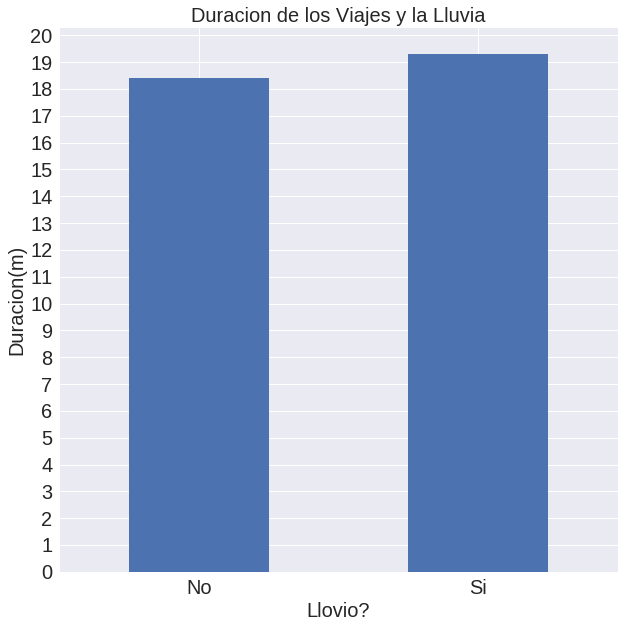

In [45]:
joined[['lluvia', 'duration_m']].groupby('lluvia').aggregate('mean').plot.bar(figsize=(10,10), fontsize=20, rot=0);
plt.yticks(range(0,21,1));
plt.xlabel('Llovio?', fontsize=20);
plt.ylabel('Duracion(m)', fontsize=20)
plt.title('Duracion de los Viajes y la Lluvia', fontsize=20);
plt.legend('');

Es interesante lo que se puede obtener de este plot. Si bien se realizan muchos más viajes cuando no llueve que cuando llueve, la duración promedio de los viajes cuando llueve es mayor que cuando no llueve. Teniendo en cuenta que hay muchos menos viajes con lluvia que sin lluvia y que eso puede afectar el promedio, esto vuelve a indicar que los viajes que se realizan cuando llueve se producirían cuando la intensidad de la lluvia es baja.

### 2.5.C) Conclusión de Viajes y Lluvia

La conclusión de esta serie de plots es muy clara, se realizan más viajes cuando no llueve que cuando llueve. Pero las duraciones de los viajes que se realizan cuando llueve son mayores que las duraciones de un viaje promedio cuando no llueve. Como se menciono previamente ese dato puede ser engañoso, pero una posible causa por la cual se presenta este fenómeno es que los viajes se realizan cuando la lluvia tiene una intensidad baja.